In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from math import sqrt
import scipy.sparse as scs
import matplotlib.pyplot as plt
import seaborn as sns
from random import uniform
from tqdm.notebook import tqdm

import json
import joblib
import pickle

from lightfm import LightFM
from implicit.als import AlternatingLeastSquares
from implicit.bpr import BayesianPersonalizedRanking
from rankfm.rankfm import RankFM
from implicit.nearest_neighbours import BM25Recommender
from scipy.sparse.linalg import svds
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

from category_encoders.leave_one_out import LeaveOneOutEncoder
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from scipy.sparse import lil_matrix, save_npz, load_npz
from typing import List, Dict

sns.set_style('whitegrid')

## Загрузка данных
### Загружаем матрицы user-item

In [2]:
train = pd.read_csv('train_10k.csv')
test = pd.read_csv('test_10k.csv')
train.head()

,user_id,song_id,play_count,title,release,artist_name,year,genre,artist_country,artist_city
0,6fbf6970611d01e10aebeab374f461116155867e,SOPVPCY12A81C23555,1,Unlove You (Album Version),Headstrong,Ashley Tisdale,2007,pop_rock,United States,Ocean Township
1,fa8a8753518e6c2d3713990dc2a172ea17000b80,SOBSMEQ12AB018282F,1,Towards The Sun,Away We Go Original Motion Picture Soundtrack,Alexi Murdoch,2009,soundtrack,United Kingdom,London
2,c9fdf63587a7a963e383ea2f1b58d1014377caab,SONQEYS12AF72AABC9,1,Mr. Jones,Films About Ghosts (The Best Of Counting Crows),Counting Crows,1991,rock,United States,Berkeley
3,e329cc2012d31242297d294fa0279b79a1bd5cc7,SOHTAXD12A8C141E75,1,Scratch Tail,Collide,Beats Antique,2008,electronic,United States,Oakland
4,2a9178398fa6377a340d5b9b6be87de32b4059a2,SOAWWJW12AB01814F5,2,Don't Haunt This Place,Hometowns,The Rural Alberta Advantage,2008,rock,Canada,Toronto


In [3]:
train_sparse = scs.load_npz('train_10k_sparse_matrix.npz')
train_sparse

<10000x88058 sparse matrix of type '<class 'numpy.float64'>'
	with 682428 stored elements in COOrdinate format>

In [4]:
test_sparse = scs.load_npz('test_10k_sparse_matrix.npz')
test_sparse

<10000x88058 sparse matrix of type '<class 'numpy.float64'>'
	with 170607 stored elements in COOrdinate format>

In [5]:
with open('users_10k_id_for_sparse.txt', 'r') as fp:
    users_id_for_sparse = json.load(fp)
    
with open('songs_10k_id_for_sparse.txt', 'r') as fp:
    songs_id_for_sparse = json.load(fp)

In [6]:
def replace_user_id(x):
    return users_id_for_sparse[x]

def replace_song_id(x):
    return songs_id_for_sparse[x]

In [7]:
train['user_id'] = train.user_id.apply(replace_user_id)
train['song_id'] = train.song_id.apply(replace_song_id)

test['user_id'] = test.user_id.apply(replace_user_id)
test['song_id'] = test.song_id.apply(replace_song_id)

In [8]:
train.head()

,user_id,song_id,play_count,title,release,artist_name,year,genre,artist_country,artist_city
0,4337,55701,1,Unlove You (Album Version),Headstrong,Ashley Tisdale,2007,pop_rock,United States,Ocean Township
1,9767,6227,1,Towards The Sun,Away We Go Original Motion Picture Soundtrack,Alexi Murdoch,2009,soundtrack,United Kingdom,London
2,7908,48367,1,Mr. Jones,Films About Ghosts (The Best Of Counting Crows),Counting Crows,1991,rock,United States,Berkeley
3,8867,28004,1,Scratch Tail,Collide,Beats Antique,2008,electronic,United States,Oakland
4,1625,3134,2,Don't Haunt This Place,Hometowns,The Rural Alberta Advantage,2008,rock,Canada,Toronto


In [9]:
train.to_csv('train_fm.csv')
test.to_csv('test_fm.csv')

In [10]:
num_users, num_songs = train.user_id.nunique(), max([train.song_id.max(), test.song_id.max()])
num_users, num_songs

(10000, 88057)

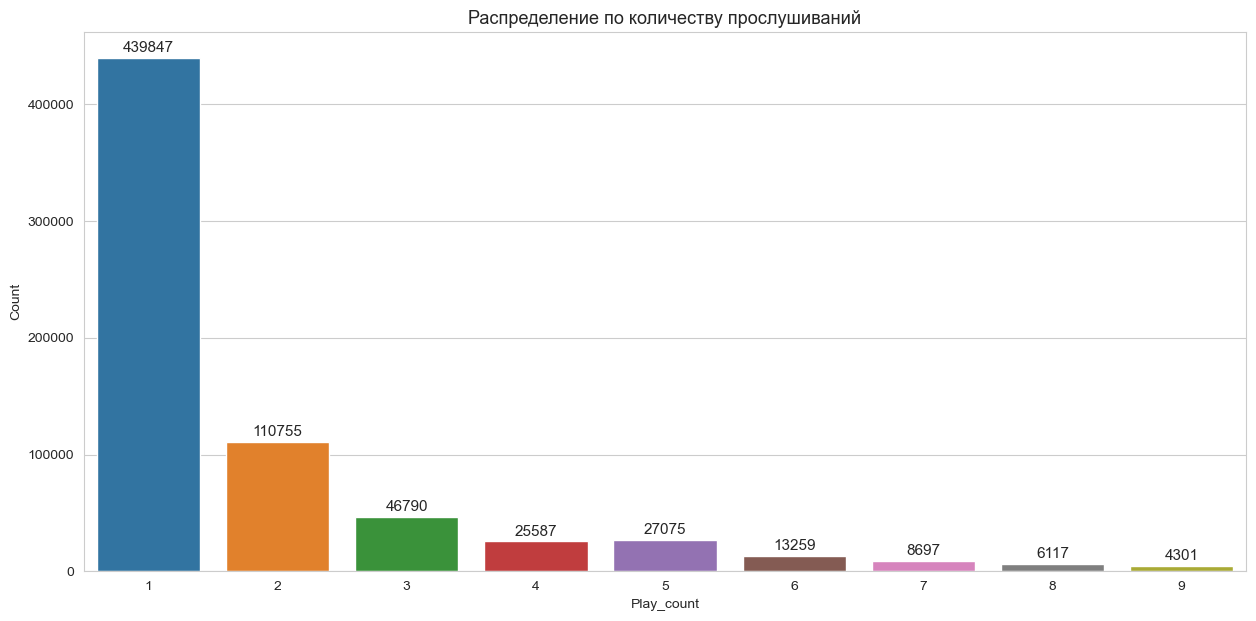

In [11]:
fig = plt.figure(figsize = (15, 7))

ax = sns.countplot(x='play_count', data=train);

for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 5000, 
            rect.get_height(), horizontalalignment='center', fontsize = 11)

plt.title('Распределение по количеству прослушиваний', fontsize=13);
plt.ylabel('Count', fontsize=10);
plt.xlabel('Play_count',  fontsize=10);

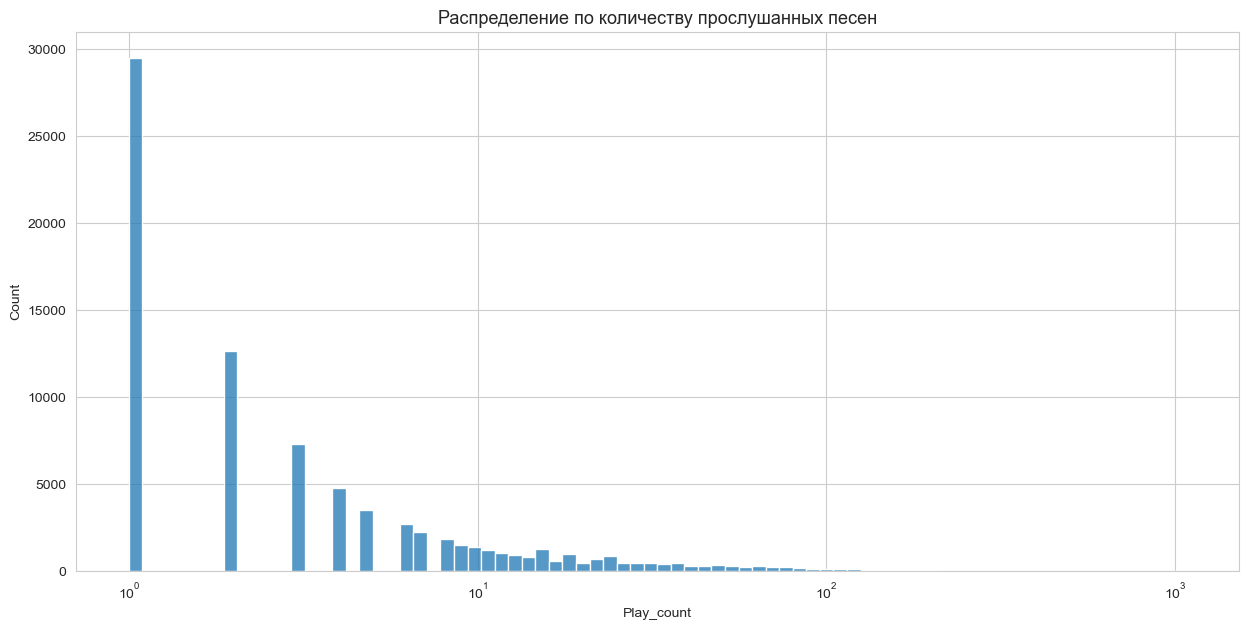

In [12]:
fig = plt.figure(figsize = (15, 7))

sns.histplot(train.groupby('song_id').size(), log_scale=True);

plt.title('Распределение по количеству прослушанных песен', fontsize=13);
plt.ylabel('Count', fontsize=10);
plt.xlabel('Play_count',  fontsize=10);

### Создаем матрицу для item-features для LightFM

In [13]:
test_zero = test.copy()
test_zero['play_count'] = 0

Чтобы избежать переобучения обнулим количество прослушиваний песен для теста и объединим тест и трейн.

In [14]:
test_zero.head()

,user_id,song_id,play_count,title,release,artist_name,year,genre,artist_country,artist_city
0,1234,11506,0,You Appearing,Saturdays = Youth,M83,2008,electronic,France,Antibes
1,6261,56945,0,The Old Homestead (Remastered Album Version),Hawks & Doves,Neil Young,1980,rock,Canada,Toronto
2,9153,85415,0,One,...And Justice For All,Metallica,1988,rock,United States,Los Angeles
3,8483,87056,0,Tú,Shakira MTV Unplugged,Shakira,1998,pop,Colombia,Barranquilla
4,8246,69701,0,Hustla Balla Gangsta Mack,Rich Boy,Rich Boy,2007,hiphop,United States,Mobile


In [15]:
data_10k = pd.concat([train, test_zero])
data_10k.shape

(853035, 10)

In [16]:
song_10k = data_10k[['song_id', 'play_count', 'release', 'artist_name', 
                     'year', 'genre', 'artist_country', 'artist_city']].drop_duplicates()
song_10k.head()

,song_id,play_count,release,artist_name,year,genre,artist_country,artist_city
0,55701,1,Headstrong,Ashley Tisdale,2007,pop_rock,United States,Ocean Township
1,6227,1,Away We Go Original Motion Picture Soundtrack,Alexi Murdoch,2009,soundtrack,United Kingdom,London
2,48367,1,Films About Ghosts (The Best Of Counting Crows),Counting Crows,1991,rock,United States,Berkeley
3,28004,1,Collide,Beats Antique,2008,electronic,United States,Oakland
4,3134,2,Hometowns,The Rural Alberta Advantage,2008,rock,Canada,Toronto


In [17]:
song_10k = song_10k.groupby(['song_id', 'release', 'artist_name', 'year', 'genre', 
                             'artist_country', 'artist_city'], as_index=False).agg({'play_count': 'sum'})

Получим датасет с уникальными песнями и их фичами, включая целевую переменную - play_count.

In [18]:
song_10k = song_10k.sort_values(by='song_id')
song_10k.head()

,song_id,release,artist_name,year,genre,artist_country,artist_city,play_count
0,0,The Room,Harold Budd,2000,ambient,United States,Los Angeles,0
1,1,Have Yourself A Tractors Christmas,The Tractors,1995,country,United States,Tulsa,1
2,2,At the Cut,Vic Chesnutt,2009,rock,United States,Jacksonville,0
3,3,20 Años,Alejandro Lerner,1998,latin,Argentina,Buenos Aires,3
4,4,Sefronia,Tim Buckley,1973,folk,United States,Washington,0


In [19]:
song_10k.shape

(88058, 8)

In [20]:
cat_cols = ['release', 'artist_name', 'year', 'genre', 'artist_country', 'artist_city']

In [21]:
pipe = Pipeline([('enc', LeaveOneOutEncoder(cols=cat_cols)), 
                ('scaler', StandardScaler())])

In [22]:
song_features = pipe.fit_transform(song_10k.drop('song_id', axis=1), song_10k.play_count)
song_features.shape

(88058, 7)

In [23]:
items_features = scs.csr_matrix(song_features)
items_features

<88058x7 sparse matrix of type '<class 'numpy.float64'>'
	with 616406 stored elements in Compressed Sparse Row format>

### Подготовка данных для RankFM

In [25]:
data = pd.concat([train, test])
data

,user_id,song_id,play_count,title,release,artist_name,year,genre,artist_country,artist_city
0,4337,55701,1,Unlove You (Album Version),Headstrong,Ashley Tisdale,2007,pop_rock,United States,Ocean Township
1,9767,6227,1,Towards The Sun,Away We Go Original Motion Picture Soundtrack,Alexi Murdoch,2009,soundtrack,United Kingdom,London
2,7908,48367,1,Mr. Jones,Films About Ghosts (The Best Of Counting Crows),Counting Crows,1991,rock,United States,Berkeley
3,8867,28004,1,Scratch Tail,Collide,Beats Antique,2008,electronic,United States,Oakland
4,1625,3134,2,Don't Haunt This Place,Hometowns,The Rural Alberta Advantage,2008,rock,Canada,Toronto
...,...,...,...,...,...,...,...,...,...,...
170602,8176,70411,1,Goodbye,Goodbye,Kristinia DeBarge,2009,pop,United States,South Pasadena
170603,5408,61673,1,Da Bump,Muddy Waters,Redman,1996,hiphop,United States,Newark
170604,6062,40013,1,Love Deep Inside,Love Deep Inside,Rico Bernasconi,2009,dance,Germany,Menden (Sauerland)
170605,1356,23834,1,Out Of Your Life,Poison Years,Bob Mould,1990,rock,United States,Malone


In [26]:
realese_encoder = LabelEncoder()
artist_name_encoder = LabelEncoder()
artist_country_encoder = LabelEncoder()
artist_city_encoder = LabelEncoder()
genre_encoder = LabelEncoder()

realese_encoder.fit(data['release'])
artist_name_encoder.fit(data['artist_name'])
artist_country_encoder.fit(data['artist_country'])
artist_city_encoder.fit(data['artist_city'])
genre_encoder.fit(data['genre'])

train['release'] = realese_encoder.transform(train['release'])
train['artist_name'] = artist_name_encoder.transform(train['artist_name'])
train['artist_country'] = artist_country_encoder.transform(train['artist_country'])
train['artist_city'] = artist_city_encoder.transform(train['artist_city'])
train['genre'] = genre_encoder.transform(train['genre'])

test['release'] = realese_encoder.transform(test['release'])
test['artist_name'] = artist_name_encoder.transform(test['artist_name'])
test['artist_country'] = artist_country_encoder.transform(test['artist_country'])
test['artist_city'] = artist_city_encoder.transform(test['artist_city'])
test['genre'] = genre_encoder.transform(test['genre'])

In [27]:
item_features_train = train.drop(['user_id', 'play_count', 'title'], axis=1).drop_duplicates()
item_features_test = test.drop(['user_id', 'play_count', 'title'], axis=1).drop_duplicates()

In [28]:
scaler = MinMaxScaler()
scaled_cols = item_features_train.columns[1:]
scaler.fit(item_features_train[scaled_cols])

item_features_train[scaled_cols] = scaler.transform(item_features_train[scaled_cols])
item_features_test[scaled_cols] = scaler.transform(item_features_test[scaled_cols])

In [29]:
interactions_train = train[['user_id', 'song_id']]
interactions_test = test[['user_id', 'song_id']]

In [30]:
sample_weight_train = np.log2(train['play_count'] + 1)
sample_weight_valid = np.log2(test['play_count'] + 1)

## Обучение моделей
### Random

In [31]:
def get_random_preds(k=10):
    preds = np.tile(np.arange(num_songs), (num_users, 1))
    for i in range(num_users):
        rand_perm = np.random.permutation(num_songs)
        preds[i] = preds[i][rand_perm]

    preds = remove_train_items(preds, k)
    
    return preds

### Popularity Based Filtering

In [32]:
def remove_train_items(preds, k):
    new_preds = np.zeros((preds.shape[0], k), dtype=int)
    for user, data in train.groupby('user_id'):
        user_preds = preds[user]
        new_preds[user] = user_preds[~np.in1d(user_preds, data.song_id)][:k]
    return new_preds


def get_toppop_preds(freq=10, k=10):
    mean_rating = train.groupby('song_id').play_count.mean()
    mean_rating = mean_rating[train.groupby('song_id').size() >= freq]
    preds = np.array(mean_rating.sort_values(ascending=False).index)
    preds = np.tile(preds, (num_users, 1))
    preds = remove_train_items(preds, k)
    
    return preds

### ALS

In [33]:
def ALS(train_sparse, users, items, dim=64, n_iters=1, eps=1e-7):
    
    num_users = train_sparse.shape[0]
    num_items = train_sparse.shape[1]
    
    R = train_sparse.copy()
    print(R.shape)
    P = np.random.randn(num_users, dim)
    print(P.shape)
    Q = np.random.randn(num_items, dim)
    print(Q.shape)
    
    for t in tqdm(range(n_iters)):
        RQ = R @ Q
        for u in range(num_users):
            relevant_items = items[users == u]
            Q_rel = Q[relevant_items]
            QQ = Q_rel.reshape(-1, dim, 1) * Q_rel.reshape(-1, 1, dim)
            P[u] = np.linalg.inv(QQ.sum(axis=0) + eps * np.eye(dim)) @ RQ[u]

        RP = R.T @ P
        for i in range(num_items):
            relevant_users = users[items == i]
            P_rel = P[relevant_users]
            PP = P_rel.reshape(-1, dim, 1) * P_rel.reshape(-1, 1, dim)
            Q[i] = np.linalg.inv(PP.sum(axis=0) + eps * np.eye(dim)) @ RP[i]
    
    return P, Q

In [35]:
P, Q = ALS(train_sparse, train.user_id, train.song_id, n_iters=5)

In [36]:
def get_ALS_preds(U, V, k=10):
    preds = np.argsort(U @ V.T, axis=1)
    preds = remove_train_items(preds, k)
    
    return preds

### Implicit ALS

In [37]:
def get_implicit_pred(train_sparse, k):
    user_items_data = train_sparse.copy().tocsr()
    model = AlternatingLeastSquares(factors=50)
    model.fit(user_items_data)
    implicit_pred = []

    for i in range(10000):
        recommendations = model.recommend(i, user_items_data[i], N=k)[0]
        implicit_pred.append(recommendations)
        
    return implicit_pred

### LightFm

In [38]:
modelFM = LightFM(no_components=200,
                  loss='warp', 
                  user_alpha=6e-5, 
                  item_alpha=2e-5, 
                  learning_rate=0.01, 
                  random_state=42,
                  max_sampled=100)

In [39]:
epochs = 1
rounds = 10
for rounds in tqdm(range(rounds)):
    modelFM.fit_partial(train_sparse, 
                       sample_weight=train_sparse, 
                       epochs=epochs, 
                       num_threads=8,
                       item_features=items_features,
                       user_features=train_sparse)

In [40]:
modelFM = joblib.load('LightFM.pkl')

In [41]:
pred = []
for row_id in tqdm(np.arange(test_sparse.shape[0])):
    score = pd.Series(modelFM.predict(int(row_id), np.arange(test_sparse.shape[1]), 
                                      item_features=items_features,
                                      user_features=test_sparse,
                                      num_threads=8))
    score.index = np.arange(test_sparse.shape[1])
    score = list(pd.Series(score.sort_values(ascending=False).index))
    
    pred_items = score[:50]
    
    pred.append(pred_items)

### SVD

In [42]:
def get_SVD_pred(train_sparse, test_sparse, ks):
    u, s, vt = svds(train_sparse, k=10)
    s_diag_matrix = np.diag(s)
    X_pred = np.dot(np.dot(u, s_diag_matrix), vt)
    
    pred_svd = []
    for row_id in tqdm(np.arange(test_sparse.shape[0])):
        score = pd.Series(X_pred[row_id, :])
        score = list(pd.Series(score.sort_values(ascending=False).index))

        pred_items = score[:ks]
        pred_svd.append(pred_items)
        
    return pred_svd

### BM25

In [43]:
def get_bm25_pred(train_sparse, k):
    user_items_data = train_sparse.copy().tocsr()
    model_bm25 = BM25Recommender(K=100, K1=0.05, B=0.05)
    model_bm25.fit(user_items_data)
    
    bm25_pred = []
    user_items = user_items_data
    for i in range(10000):
        recommendations = model_bm25.recommend(i, user_items[i], N=k)[0]
        bm25_pred.append(recommendations)
        
    return bm25_pred

### RankFM

In [44]:
def get_rankfm_pred(interactions_train, item_features_train, sample_weight_train, k):
    model = RankFM(factors=100, 
               loss='warp', 
               max_samples=100, 
               alpha=0.05, 
               sigma=0.1, 
               learning_rate=0.1, 
               learning_schedule='invscaling')
    
    model.fit(interactions_train, item_features=item_features_train, 
              sample_weight=sample_weight_train, epochs=100, verbose=False)
    
    users = [i for i in range(interactions_train['user_id'].nunique())]
    pred_rankfm = model.recommend(users, n_items=30, filter_previous=True)
    pred_rankfm = pred_rankfm.to_numpy()
    
    return pred_rankfm

## Оценка качества моделей
Оценим качество моделей с помощью реализованных нами метрик.

In [45]:
from metrics import precision_k, recall_k, MAP_k, MAR_k, nDCG_k
from metrics import calculate_coverage, calculate_personalization, calculate_novelty

Получим истинные и предсказанные значения для каждой модели.

In [46]:
true_relevant = []
for user, data in test[test.play_count >= 2].groupby('user_id'):
    true_relevant += [data.song_id.tolist()]

In [47]:
ks = np.arange(1, 31)

In [48]:
random_preds = get_random_preds(k=ks[-1])
top_preds = get_toppop_preds(freq=10, k=ks[-1])
als_preds = get_ALS_preds(P, Q, k=ks[-1])
implicit_pred = get_implicit_pred(train_sparse, k=ks[-1])
pred_svd = get_SVD_pred(train_sparse, test_sparse, ks=ks[-1])
bm25_pred = get_bm25_pred(train_sparse, k=ks[-1])
pred_rankfm = get_rankfm_pred(interactions_train, item_features_train, sample_weight_train, k=ks[-1])

In [49]:
with open('LF_pred.pkl', 'rb') as f:
    pred_LF = pickle.load(f)
    
with open('als_preds.pkl', 'rb') as f:
    als_preds = pickle.load(f)
    
with open('implicit_pred.pkl', 'rb') as f:
    implicit_pred = pickle.load(f)
    
with open('random_preds.pkl', 'rb') as f:
    random_preds = pickle.load(f)
    
with open('top_preds.pkl', 'rb') as f:
    top_preds = pickle.load(f)
    
with open('pred_svd.pkl', 'rb') as f:
    pred_svd = pickle.load(f)
    
with open('bm25_pred.pkl', 'rb') as f:
    bm25_pred = pickle.load(f)
    
with open('pred_rankfm.pkl', 'rb') as f:
    pred_rankfm = pickle.load(f)

### Оценим качество на метриках precision@k, recall@k, MAP@k и MAR@k, nDCG@k

In [50]:
pred_LF = np.array(pred_LF)
implicit_pred = np.array(implicit_pred)
pred_svd = np.array(pred_svd)
bm25_pred = np.array(bm25_pred)

In [51]:
models = ['Random', 'Top Popular', 'LightFM', 'ALS', 'Implicit ALS', 'SVD', 'BM25', 'RankFM']
predictions = [random_preds, top_preds, pred_LF, als_preds, implicit_pred, pred_svd, bm25_pred, pred_rankfm]

In [52]:
def plot_precision_k(predictions, models):
    
    plt.figure(figsize=(10, 6))

    for pred, model in zip(predictions, models):
        model_pr_k = [precision_k(true_relevant, pred, k=k) for k in ks]
        plt.plot(ks, model_pr_k, label=model)
        
    plt.legend(title='method')
    plt.xlabel('k')
    plt.ylabel('precision@k')
    plt.show()
        

def plot_recall_k(predictions, models):
    
    plt.figure(figsize=(10, 6))

    for pred, model in zip(predictions, models):
        model_rl_k = [recall_k(true_relevant, pred, k=k) for k in ks]
        plt.plot(ks, model_rl_k, label=model)
        
    plt.legend(title='method')
    plt.xlabel('k')
    plt.ylabel('recall@k')
    plt.show()
        
        
def plot_MAP_k(predictions, models):
    
    plt.figure(figsize=(10, 6))

    for pred, model in zip(predictions, models):
        model_map_k = [MAP_k(true_relevant, pred, k=k) for k in ks]
        plt.plot(ks, model_map_k, label=model)
        
    plt.legend(title='method')
    plt.xlabel('k')
    plt.ylabel('MAP@k')
    plt.show()
        
        
def plot_MAR_k(predictions, models):
    
    plt.figure(figsize=(10, 6))

    for pred, model in zip(predictions, models):
        model_mar_k = [MAR_k(true_relevant, pred, k=k) for k in ks]
        plt.plot(ks, model_mar_k, label=model)
        
    plt.legend(title='method')
    plt.xlabel('k')
    plt.ylabel('MAR@k')
    plt.show()
        
        
def plot_nDCG_k(predictions, models):
    
    plt.figure(figsize=(10, 6))

    for pred, model in zip(predictions, models):
        model_ndcg_k = [nDCG_k(true_relevant, pred, k=k) for k in ks]
        plt.plot(ks, model_ndcg_k, label=model)
        
    plt.legend(title='method')
    plt.xlabel('k')
    plt.ylabel('nDCG@k')
    plt.show()

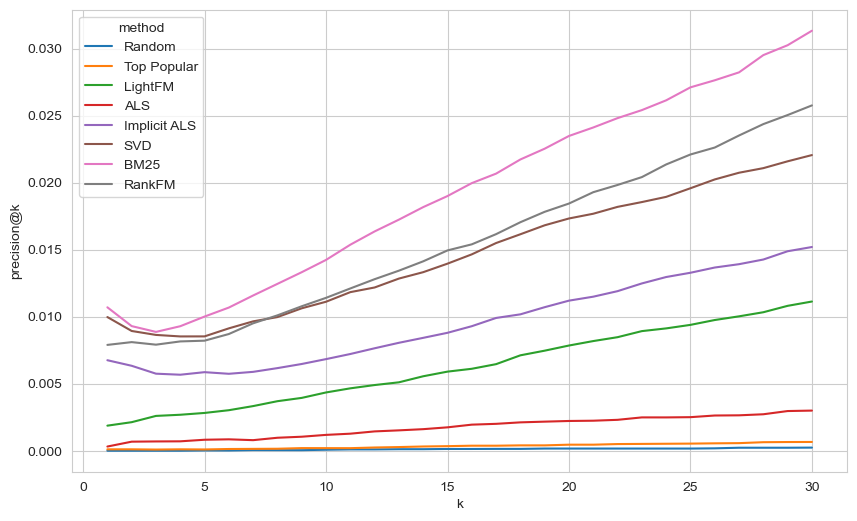

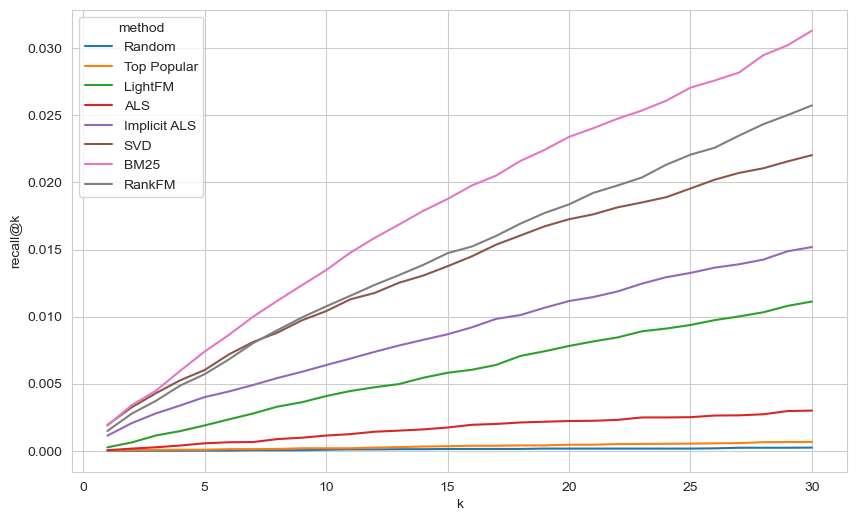

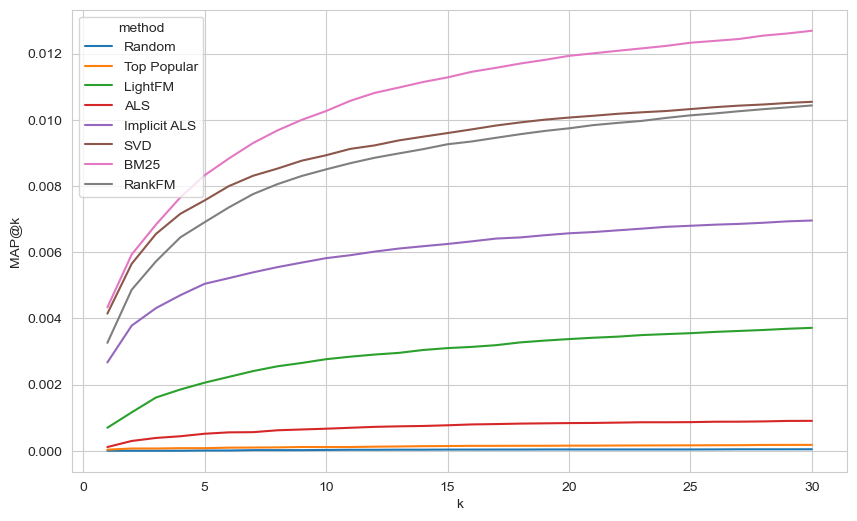

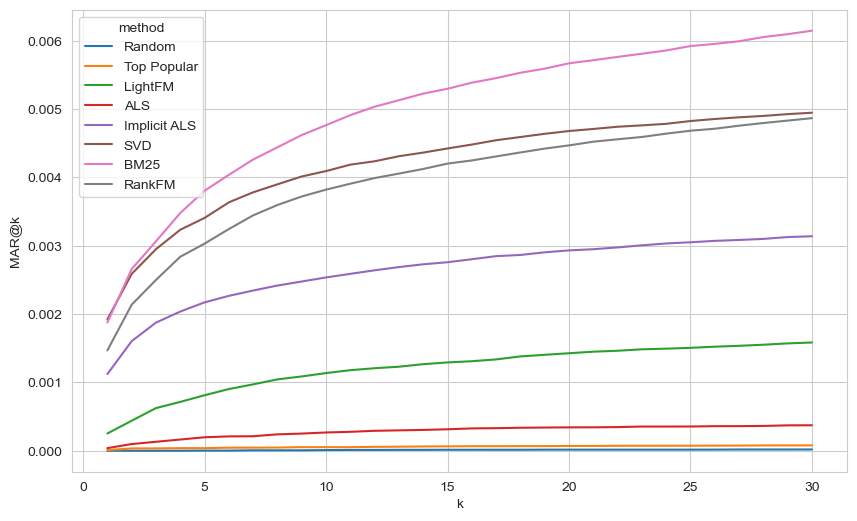

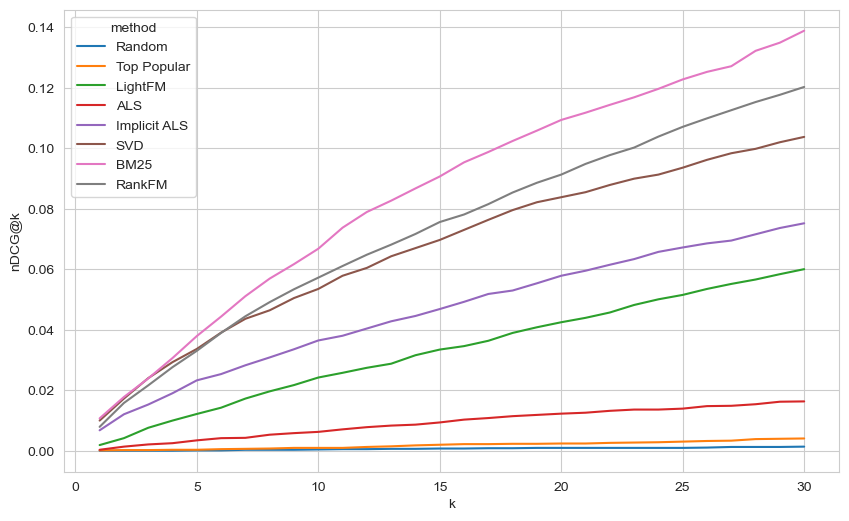

In [53]:
plot_precision_k(predictions, models)
plot_recall_k(predictions, models)
plot_MAP_k(predictions, models)
plot_MAR_k(predictions, models)
plot_nDCG_k(predictions, models)

### Также оценим другие метрики, которые измеряют разнообразие предсказаний: 
* Coverage — это процент треков из базы, которые модель может рекомендовать.
* Personalization — отличный способ оценить, рекомендует ли модель одни и те же треки разным пользователям. Вычисляется как среднее косинусное расстояние между бинарными векторами рекомендаций для разных пользователей.
* Novelty — оценка отражает уровень новизны в рекомендуемых песнях для группы пользователей. Более высокий балл указывает на более высокий уровень новизны в рекомендуемых items, что означает, что рекомендуемые items больше отличаются от items, с которыми пользователи взаимодействовали в прошлом.

In [54]:
coverage = []

for pred, model in zip(predictions, models):
    c = round(calculate_coverage(pred, num_songs), 4)
    coverage.append(c)
    print(f'{model} coverage: {c}')

Random coverage: 0.9667
Top Popular coverage: 0.0004
LightFM coverage: 0.0072
ALS coverage: 0.0131
Implicit ALS coverage: 0.0277
SVD coverage: 0.0038
BM25 coverage: 0.079
RankFM coverage: 0.1353


In [55]:
personalization = []

for pred, model in zip(predictions, models):
    p = round(calculate_personalization(pred, num_users, num_songs), 4)
    personalization.append(p)
    print(f'{model} personalization: {p}')

Random personalization: 0.9997
Top Popular personalization: 0.0025
LightFM personalization: 0.3401
ALS personalization: 0.7852
Implicit ALS personalization: 0.9398
SVD personalization: 0.7998
BM25 personalization: 0.618
RankFM personalization: 0.736


In [56]:
popularity = train.groupby('song_id', as_index=False).agg({'play_count': 'sum'})

item_frequencies = dict(zip(popularity.song_id, popularity.play_count))

In [57]:
novelty = []

for pred, model in zip(predictions, models):
    n = round(calculate_novelty(pred, item_frequencies), 4)
    novelty.append(n)
    print(f'{model} novelty: {n}')

Random novelty: 14.4588
Top Popular novelty: 4.9492
LightFM novelty: 8.625
ALS novelty: 10.0152
Implicit ALS novelty: 10.7606
SVD novelty: 8.0299
BM25 novelty: 11.8396
RankFM novelty: 12.2754


### Итоги
#### Для наглядности соберем все метрики в одной таблице

In [61]:
def calculation_metrics(true_relevant, predictions, k):
    precision =[]
    recall = []
    MAP = []
    MAR = []
    ndcg = []
    
    for pred in predictions:
        precision.append(precision_k(true_relevant, pred, k))
        recall.append(recall_k(true_relevant, pred, k))
        MAP.append(MAP_k(true_relevant, pred, k))
        MAR.append(MAR_k(true_relevant, pred, k))
        ndcg.append(nDCG_k(true_relevant, pred, k))
        
    return precision, recall, MAP, MAR, ndcg

In [62]:
precision_5k, recall_5k, map_5k, mar_5k, ndcg_5k = calculation_metrics(true_relevant, predictions, k=5)
precision_10k, recall_10k, map_10k, mar_10k, ndcg_10k = calculation_metrics(true_relevant, predictions, k=10)

In [63]:
columns = ['precision@5', 'precision@10',
           'recall@5', 'recall10', 
           'MAP@5', 'MAP@10',
           'MAR@5', 'MAR@10',
           'nDCG@5', 'nDCG@10', 
           'coverage', 'personalization', 'novelty']

model_metrics = np.array([precision_5k, precision_10k, 
                          recall_5k, recall_10k,
                          map_5k, map_10k,
                          mar_5k, mar_10k,
                          ndcg_5k, ndcg_10k, 
                          coverage, personalization, novelty])

In [64]:
pd.DataFrame(model_metrics.T, models, columns)

,precision@5,precision@10,recall@5,recall10,MAP@5,MAP@10,MAR@5,MAR@10,nDCG@5,nDCG@10,coverage,personalization,novelty
Random,0.000021,0.000074,0.000009,0.000073,0.000007,0.000024,0.000002,0.000009,0.000104,0.000415,0.9667,0.9997,14.4588
Top Popular,0.000093,0.000193,0.000075,0.000183,0.000077,0.000112,0.000038,0.000052,0.000312,0.000935,0.0004,0.0025,4.9492
LightFM,0.002818,0.004346,0.001885,0.004073,0.002056,0.002765,0.000812,0.001136,0.012151,0.024198,0.0072,0.3401,8.6250
ALS,0.000819,0.001181,0.000554,0.001129,0.000513,0.000665,0.000197,0.000267,0.003427,0.006231,0.0131,0.7852,10.0152
Implicit ALS,0.005859,0.006833,0.003997,0.006383,0.005042,0.005818,0.002171,0.002536,0.023263,0.036452,0.0277,0.9398,10.7606
SVD,0.008528,0.011112,0.006013,0.010404,0.007562,0.008927,0.003407,0.004093,0.033648,0.053484,0.0038,0.7998,8.0299
BM25,0.010006,0.014232,0.007388,0.013463,0.008323,0.010263,0.003805,0.004764,0.037906,0.066777,0.0790,0.6180,11.8396
RankFM,0.008208,0.011403,0.005706,0.010759,0.006903,0.008501,0.003031,0.003821,0.033025,0.057223,0.1353,0.7360,12.2754


## Стекинг моделей

Исходя из результатов метрик моделей подберем веса для стекинга: минимальный вклад отведем модели Top Popular, а максимальный последним четырем моделям.

In [71]:
models = ['Top Popular', 'LightFM', 'ALS', 'Implicit ALS', 'SVD', 'BM25', 'RankFM']
predictions = [top_preds, pred_LF, als_preds, implicit_pred, pred_svd, bm25_pred, pred_rankfm]

lst = []
weights_list = []
best_score = 0

for i in range(100):
    stack_pred = []
    weights = []
    
    for m in range(len(models)):
        if m == 0:
            w = uniform(0, 0.1)
        elif m < 3:
            w = uniform(0.1, 0.3)
        else:
            w = uniform(0.3, 1)
        weights.append(w)
        
    weights_list.append(np.array(weights) / sum(weights))

In [72]:
best_score = 0
lst = []

for weights in tqdm(weights_list):
    stack_pred = []
    
    for i in range(10000):
        stacker = {}
        
        for pred, model, w in zip(predictions, models, weights):

            for k, item in enumerate(pred[i][:ks[-1]]):
                if item in stacker:
                    stacker[item] += w
                else:
                    stacker[item] = w

        stack_pred.append(sorted(stacker, key=stacker.get, reverse=True)[:ks[-1]])

    stack_pred = np.array(stack_pred)

    stack_cov = calculate_coverage(stack_pred, num_songs) 
    stack_prs = calculate_personalization(stack_pred, num_users, num_songs)
    stack_nvl = calculate_novelty(stack_pred, item_frequencies)
    stack_map = MAP_k(true_relevant, stack_pred, 10)
    score = sum([stack_cov * 10, stack_prs, stack_map * 100, stack_nvl/100])

    if score > best_score:
        best_score = score

    d = {'score': score, 'coverage': stack_cov, 'personalization': stack_prs,
         'novelty': stack_nvl, 'MAP_k': stack_map, 'weights': weights}
    lst.append(d)

  0%|          | 0/100 [00:00<?, ?it/s]

In [73]:
for l in lst:
    if l['score'] == best_score:
        best_weights = l['weights']

In [74]:
with open('best_weights.pkl', 'rb') as f:
    best_weights = pickle.load(f)

In [76]:
stack_pred = []

for i in range(10000):
    stacker = {}
    for pred, model, w in zip(predictions, models, best_weights):
        
        for k, item in enumerate(pred[i][:ks[-1]]):
            if item in stacker:
                stacker[item] += w
            else:
                stacker[item] = w
                
    stack_pred.append(sorted(stacker, key=stacker.get, reverse=True)[:ks[-1]])
    
stack_pred = np.array(stack_pred)

In [77]:
models = ['Random', 'Top Popular', 'LightFM', 'ALS', 'Implicit ALS', 'SVD', 'BM25', 'RankFM', 'Stack']
predictions = [random_preds, top_preds, pred_LF, als_preds, implicit_pred, 
               pred_svd, bm25_pred, pred_rankfm, stack_pred]

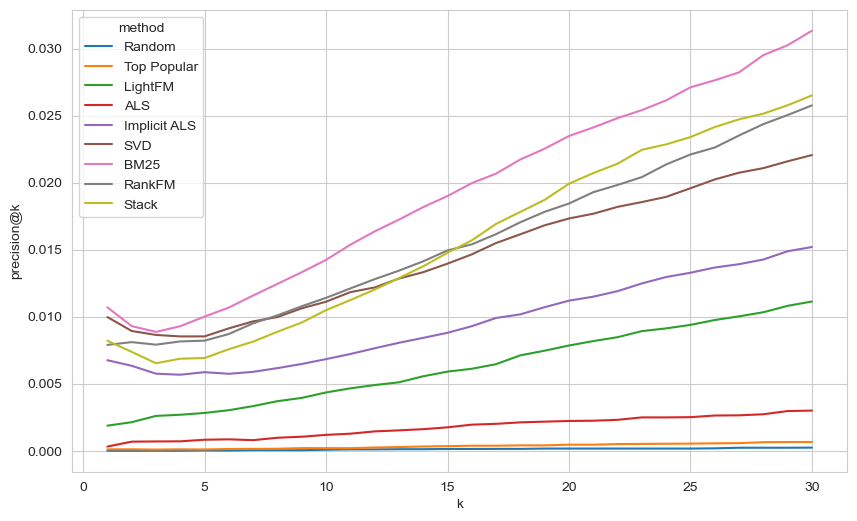

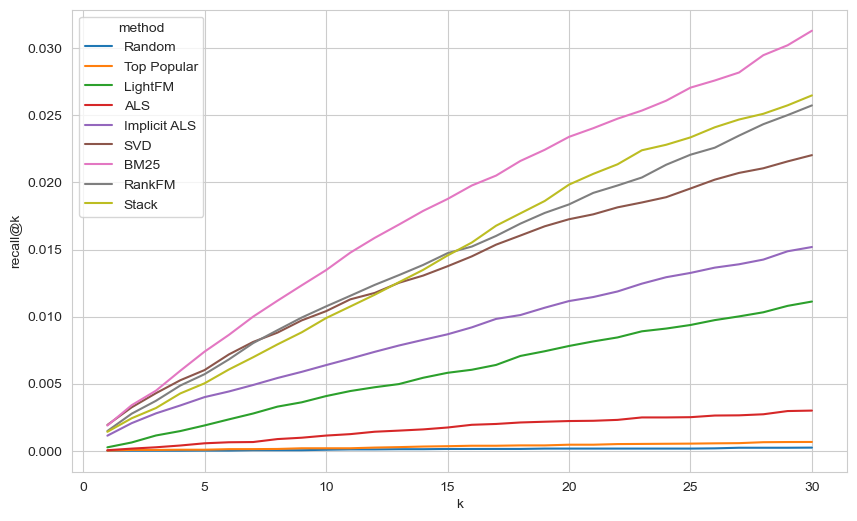

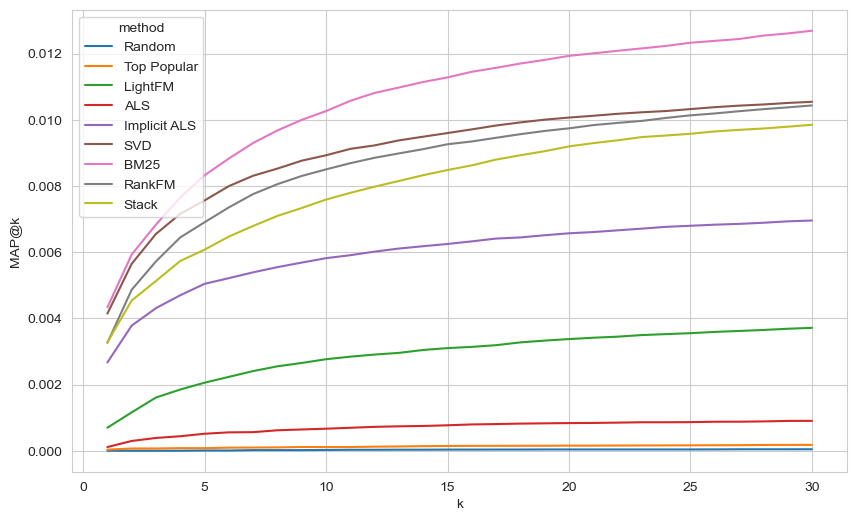

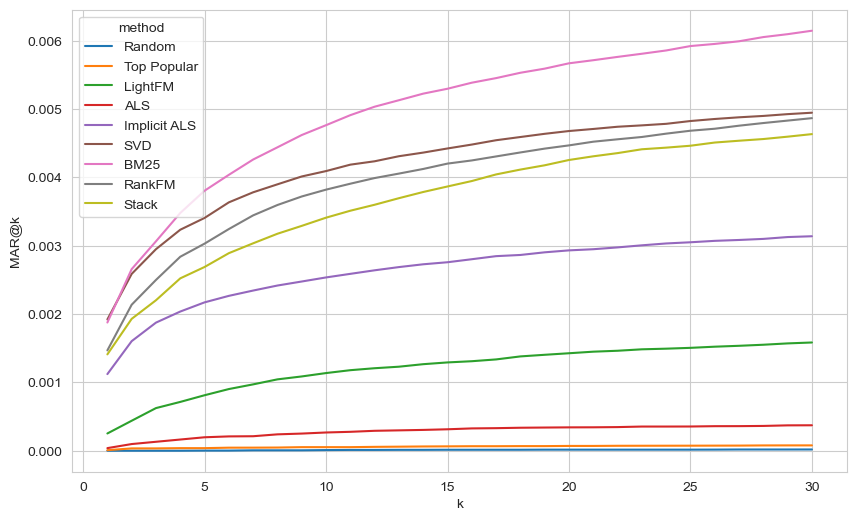

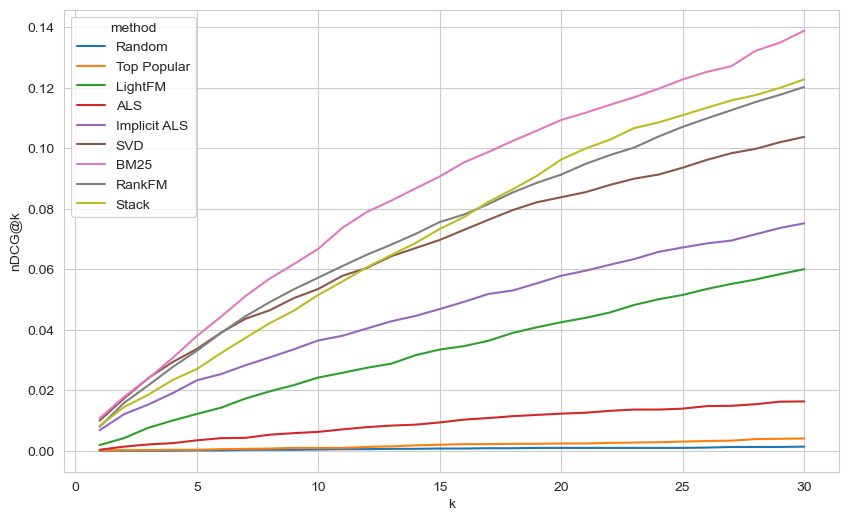

In [78]:
plot_precision_k(predictions, models)
plot_recall_k(predictions, models)
plot_MAP_k(predictions, models)
plot_MAR_k(predictions, models)
plot_nDCG_k(predictions, models)

In [79]:
coverage = []

for pred, model in zip(predictions, models):
    c = round(calculate_coverage(pred, num_songs), 4)
    coverage.append(c)
    print(f'{model} coverage: {c}')

Random coverage: 0.9667
Top Popular coverage: 0.0004
LightFM coverage: 0.0072
ALS coverage: 0.0131
Implicit ALS coverage: 0.0277
SVD coverage: 0.0038
BM25 coverage: 0.079
RankFM coverage: 0.1353
Stack coverage: 0.1071


In [80]:
personalization = []

for pred, model in zip(predictions, models):
    p = round(calculate_personalization(pred, num_users, num_songs), 4)
    personalization.append(p)
    print(f'{model} personalization: {p}')

Random personalization: 0.9997
Top Popular personalization: 0.0025
LightFM personalization: 0.3401
ALS personalization: 0.7852
Implicit ALS personalization: 0.9398
SVD personalization: 0.7998
BM25 personalization: 0.618
RankFM personalization: 0.736
Stack personalization: 0.7371


In [81]:
novelty = []

for pred, model in zip(predictions, models):
    n = round(calculate_novelty(pred, item_frequencies), 4)
    novelty.append(n)
    print(f'{model} novelty: {n}')

Random novelty: 14.4588
Top Popular novelty: 4.9492
LightFM novelty: 8.625
ALS novelty: 10.0152
Implicit ALS novelty: 10.7606
SVD novelty: 8.0299
BM25 novelty: 11.8396
RankFM novelty: 12.2754
Stack novelty: 12.0174


### Соберем все метрики в одной таблице

In [82]:
precision_5k, recall_5k, map_5k, mar_5k, ndcg_5k = calculation_metrics(true_relevant, predictions, k=5)
precision_10k, recall_10k, map_10k, mar_10k, ndcg_10k = calculation_metrics(true_relevant, predictions, k=10)

In [83]:
columns = ['precision@5', 'precision@10',
           'recall@5', 'recall10', 
           'MAP@5', 'MAP@10',
           'MAR@5', 'MAR@10',
           'nDCG@5', 'nDCG@10', 
           'coverage', 'personalization', 'novelty']

model_metrics = np.array([precision_5k, precision_10k, 
                          recall_5k, recall_10k,
                          map_5k, map_10k,
                          mar_5k, mar_10k,
                          ndcg_5k, ndcg_10k, 
                          coverage, personalization, novelty])

In [84]:
pd.DataFrame(model_metrics.T, models, columns)

,precision@5,precision@10,recall@5,recall10,MAP@5,MAP@10,MAR@5,MAR@10,nDCG@5,nDCG@10,coverage,personalization,novelty
Random,0.000021,0.000074,0.000009,0.000073,0.000007,0.000024,0.000002,0.000009,0.000104,0.000415,0.9667,0.9997,14.4588
Top Popular,0.000093,0.000193,0.000075,0.000183,0.000077,0.000112,0.000038,0.000052,0.000312,0.000935,0.0004,0.0025,4.9492
LightFM,0.002818,0.004346,0.001885,0.004073,0.002056,0.002765,0.000812,0.001136,0.012151,0.024198,0.0072,0.3401,8.6250
ALS,0.000819,0.001181,0.000554,0.001129,0.000513,0.000665,0.000197,0.000267,0.003427,0.006231,0.0131,0.7852,10.0152
Implicit ALS,0.005859,0.006833,0.003997,0.006383,0.005042,0.005818,0.002171,0.002536,0.023263,0.036452,0.0277,0.9398,10.7606
SVD,0.008528,0.011112,0.006013,0.010404,0.007562,0.008927,0.003407,0.004093,0.033648,0.053484,0.0038,0.7998,8.0299
BM25,0.010006,0.014232,0.007388,0.013463,0.008323,0.010263,0.003805,0.004764,0.037906,0.066777,0.0790,0.6180,11.8396
RankFM,0.008208,0.011403,0.005706,0.010759,0.006903,0.008501,0.003031,0.003821,0.033025,0.057223,0.1353,0.7360,12.2754
Stack,0.006913,0.010483,0.005026,0.009888,0.006075,0.007589,0.002689,0.003410,0.027002,0.051511,0.1071,0.7371,12.0174
